# Simulating the 2029 flyby of (99942) Apophis

In a few years, (99942) Apophis will pass between Earth and the Moon. Accurately simulating this flyby requires accounting for numerous sources of acceleration including the gravitational influence of all planets, relativistic effects, nongravitational accelerations from the asteroid itself, and the solar and Earth gravitational harmonics. This notebook demonstrates how to use jorbit to simulate this flyby and compares its results to those from JPL and the ASSIST package.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import pprint
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time

from jplephem.spk import SPK

import rebound
import assist
from rebound import Particle as rebound_Particle

from jorbit import Particle
from jorbit.accelerations import (
    create_default_ephemeris_acceleration_func,
    create_ephem_grav_harmonics_acceleration_func,
    nongrav_acceleration,
)
from jorbit.data.constants import (
    EARTH_J_HARMONICS,
    EARTH_RADIUS,
    SPEED_OF_LIGHT,
    SUN_J_HARMONICS,
    SUN_RADIUS,
)
from jorbit.ephemeris import Ephemeris, EphemerisProcessor
from jorbit.utils.horizons import horizons_bulk_vector_query
from jorbit.utils.states import CartesianState, SystemState, KeplerianState

times = Time(
    np.linspace(Time("2029-01-01").tdb.jd, Time("2030-01-01").tdb.jd, 1000),
    format="jd",
    scale="tdb",
)
ephem = assist.Ephem(
    "/Users/cassese/Downloads/linux_p1550p2650.440",
    "/Users/cassese/Downloads/sb441-n16.bsp",
)

To start, let's retrieve JPL's predictions for the flyby. There is some nuance here, since thanks to the unique opportunities presented by such a close approach, JPL has released several different ephemerides for Apophis. The first and most basic is what we get by querying the Horizons interface for the asteroid's position:

In [2]:
horizons_data = horizons_bulk_vector_query(target="99942", center="500@0", times=times)
jpl_horizons_xs = jnp.array(horizons_data[["x", "y", "z"]])
jpl_horizons_vs = jnp.array(horizons_data[["vx", "vy", "vz"]])

In addition to the standard Horizons interface, JPL has also released several iterations to an Apophis-specific ephemeris. We'll consider the two most recent of these, versions 218 and 220, which were published on 2023-11-06 and 2024-06-25, respectively. The SPK-transfer format files can be found at [this url](https://ssd.jpl.nasa.gov/ftp/eph/small_bodies/apophis/), but for convenience we have already converted them to binary .bsp files and included them in the jorbit repository.

These .bsp files are in slightly different format than the standard DE ephemeris files (there are multiple "segments" for the same target/center pair), so much of `jorbit`'s internal machinery can't apply unfortunately. What follows is a minimal workaround to just get at the data we need- most users will not need to use this kind of workflow and can instead use the `Ephemeris` class to interact with DE files.

In [3]:
# get the Sun's position and velocity from the usual jorbit interface-
# the Apophis SPK's are relative to the Sun, not the solar system barycenter
usual_eph = Ephemeris(ssos="default solar system")
eph_state = usual_eph.state(times)
sun_xs = eph_state["sun"]["x"].value
sun_vs = eph_state["sun"]["v"].value
earth_xs = eph_state["earth"]["x"].value
earth_vs = eph_state["earth"]["v"].value

def parse_apophis_file(filename):

    # open ephemeris
    spk = SPK.open(filename)
    starts = np.array([seg.start_jd for seg in spk.segments])
    ends = np.array([seg.end_jd for seg in spk.segments])
    order = starts.argsort()
    starts = jnp.array(starts[order])
    ends = jnp.array(ends[order])

    # create a list of EphemerisProcessor objects for each segment
    processors = []
    for ind in order:
        init, intlen, coeff = spk.segments[ind]._data
        processors.append(
            EphemerisProcessor(
                jnp.array([init]), jnp.array([intlen]), jnp.array([coeff]), jnp.array([0.0])
            )
        )

    # figure out which processor to use for each time
    processor_inds = jnp.searchsorted(starts, times.tdb.jd) - 1

    # query those processors for the state of Apophis, then subtract off the sun's position
    helio_xs = np.zeros((len(processor_inds), 3))
    helio_vs = np.zeros((len(processor_inds), 3))
    for i, (ind, t) in enumerate(zip(processor_inds, times.tdb.jd)):
        _x, _v = processors[ind].state(t)
        helio_xs[i] = _x[0]
        helio_vs[i] = _v[0]
    final_xs = helio_xs + sun_xs
    final_vs = helio_vs + sun_vs

    return jnp.array(final_xs), jnp.array(final_vs)

jpl_220_xs, jpl_220_vs = parse_apophis_file("../../paper/data/sb-99942-220.bsp")
jpl_218_xs, jpl_218_vs = parse_apophis_file("../../paper/data/sb-99942-218.bsp")

Let's compare the differences between these solutions:

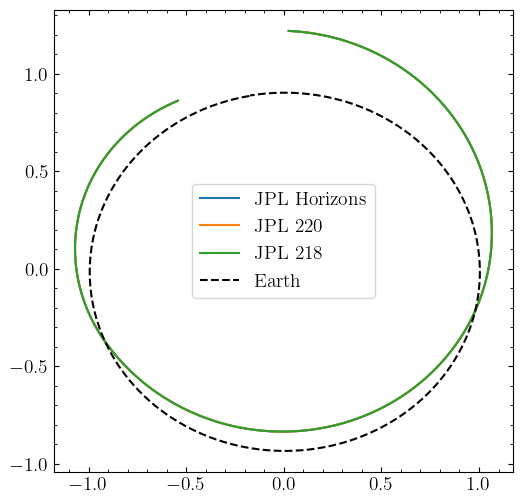

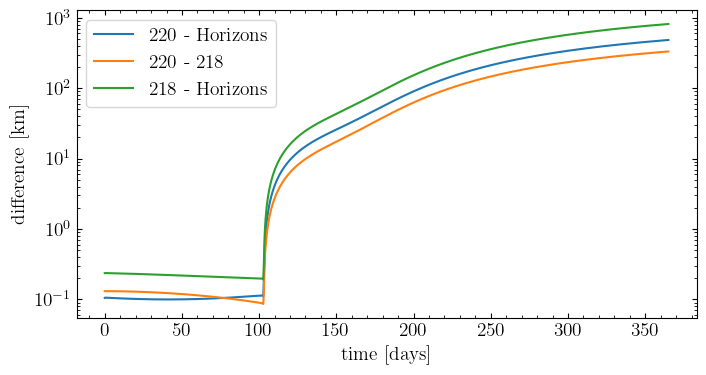

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(jpl_horizons_xs[:, 0], jpl_horizons_xs[:, 1], label="JPL Horizons")
ax.plot(jpl_220_xs[:, 0], jpl_220_xs[:, 1], label="JPL 220")
ax.plot(jpl_218_xs[:, 0], jpl_218_xs[:, 1], label="JPL 218")
ax.plot(earth_xs[:, 0], earth_xs[:, 1], label="Earth", color="black", linestyle="--")
ax.set(aspect="equal")
ax.legend()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jpl_220_xs - jpl_horizons_xs, axis=1) * u.au.to(u.km),
    label="220 - Horizons",
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jpl_220_xs - jpl_218_xs, axis=1) * u.au.to(u.km),
    label="220 - 218",
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jpl_218_xs - jpl_horizons_xs
    , axis=1) * u.au.to(u.km),
    label="218 - Horizons",
)
ax.set(yscale="log", xlabel="time [days]", ylabel="difference [km]")
ax.legend()

So, these solutions are ~a few 100m apart before the flyby, then ~a few 100km apart by the end of the year after the flyby. Moving forward we'll consider only the 220 solution.

Here's ASSIST's prediction for the flyby:

In [5]:
# start at the exact same time
apophis_initial = rebound_Particle(
    x=jpl_220_xs[0, 0],
    y=jpl_220_xs[0, 1],
    z=jpl_220_xs[0, 2],
    vx=jpl_220_vs[0, 0],
    vy=jpl_220_vs[0, 1],
    vz=jpl_220_vs[0, 2],
)


sim = rebound.Simulation()
sim.add(apophis_initial)
sim.t = times[0].tdb.jd - ephem.jd_ref
sim.ri_ias15.min_dt = 0.001
extras = assist.Extras(sim, ephem)

# Turn on GR for star and all planets
extras.gr_eih_sources = 11  

# Add the nongravitational forces (values specific to Apophis from the Horizons solution)
extras.particle_params = np.array([4.999999873689e-13, -2.901085508711e-14, 0.0])

assist_xs = np.zeros((len(times), 3))
assist_vs = np.zeros((len(times), 3))
for i, t in enumerate(times):
    extras.integrate_or_interpolate(t.tdb.jd - ephem.jd_ref)
    assist_xs[i] = sim.particles[0].xyz
    assist_vs[i] = sim.particles[0].vxyz


And here's `jorbit`'s prediction. To use `jorbit` for this simulation, we have to use the lower-level interface to construct a custom acceleration function.

In [6]:
# construct each component of the acceleration function piece-by-piece

# first, just the usual gravitational acceleration function, GR for planets, newtonian for asteroids
eph = Ephemeris(ssos="default solar system")
acc_func_grav = create_default_ephemeris_acceleration_func(
    ephem_processor=eph.processor
)

# add the J harmonics for the Sun and Earth
acc_func_solar_harmonics = create_ephem_grav_harmonics_acceleration_func(
    eph.processor, ephem_index=0, state_index=0
)
acc_func_earth_harmonics = create_ephem_grav_harmonics_acceleration_func(
    eph.processor, ephem_index=3, state_index=1
)

# combine those 3, along with the non-gravitational forces
# (which didn't need to be created separately since it just relies on SystemState)
def _acc_func(state: SystemState) -> jnp.ndarray:
    return (
        acc_func_grav(state)
        + nongrav_acceleration(state)
        + acc_func_solar_harmonics(state)
        + acc_func_earth_harmonics(state)
    )
acc_func = jax.tree_util.Partial(_acc_func)

# set the J coefficients
js = jnp.zeros((2, 3))
js = js.at[0,0].set(SUN_J_HARMONICS[0])
js = js.at[1].set(EARTH_J_HARMONICS)

c = CartesianState(
    x=jnp.array([jpl_220_xs[0]]),
    v=jnp.array([jpl_220_vs[0]]),
    time=times[0].tdb.jd,
    acceleration_func_kwargs={
        "c2": SPEED_OF_LIGHT**2,
        "a1": jnp.array([4.999999873689e-13]), # the same non-grav coefficients
        "a2": jnp.array([-2.901085508711e-14]),
        "a3": jnp.array([0.0]),
        "js_req": jnp.array([SUN_RADIUS, EARTH_RADIUS]),
        "js_pole_ra": jnp.array([286.13*jnp.pi/180, 359.99868*jnp.pi/180]), # the RA and Dec of the poles in April 2029
        "js_pole_dec": jnp.array([63.87*jnp.pi/180, 89.83523*jnp.pi/180]),
        "js": js,
    },
)

p = Particle(state=c, gravity=acc_func)
jorb_xs, jorb_vs = p.integrate(times)

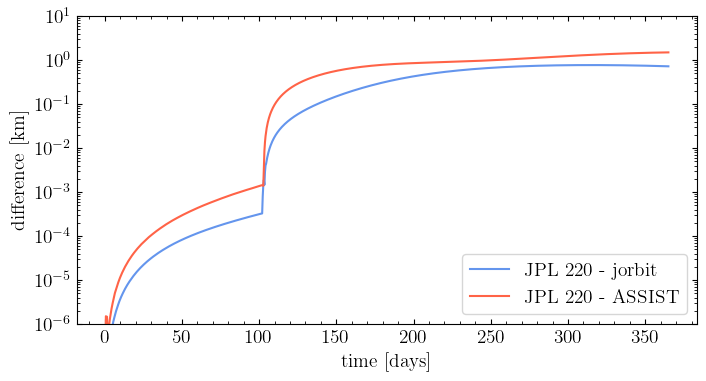

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jorb_xs - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - jorbit",
    color="cornflowerblue",
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(assist_xs - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - ASSIST",
    color="tomato",
)
ax.set(yscale="log", xlabel="time [days]", ylabel="difference [km]", ylim=(1e-6, 1e1))
ax.legend()

Both ASSIST and `jorbit` are near ~a cm off from JPL's prediction just prior to the flyby, then by the end of the year, are ~a km off. This is excellent agreement for a dynamically sensitive simulation like this and shows that both packages are capable of reproducing JPL's underlying model.

To demonstrate `jorbit`'s autodifferentiation capabilities, let's see how each input variable in Apophis' state affects it's distance from Earth in December 2029:

In [8]:
earth_pos = eph.state(times[-1])["earth"]["x"].value

@jax.jit
def earth_distance(params: dict) -> jnp.ndarray:

    js = jnp.zeros((2, 3))
    js = js.at[0, 0].set(params["sun_j2"])
    js = js.at[1, 0].set(params["earth_j2"])
    js = js.at[1, 1].set(params["earth_j3"])
    js = js.at[1, 2].set(params["earth_j4"])
    pole_ras = jnp.array([params["sun_pole_ra"], params["earth_pole_ra"]])
    pole_decs = jnp.array([params["sun_pole_dec"], params["earth_pole_dec"]])

    state = KeplerianState(
        semi=jnp.array([params["semi"]]),
        ecc=jnp.array([params["ecc"]]),
        nu=jnp.array([params["nu"]]),
        inc=jnp.array([params["inc"]]),
        Omega=jnp.array([params["Omega"]]),
        omega=jnp.array([params["omega"]]),
        time=times[0].tdb.jd,
        acceleration_func_kwargs={
            "c2": SPEED_OF_LIGHT**2,
            "a1": jnp.array([params["a1"]]),  # the same non-grav coefficients
            "a2": jnp.array([params["a2"]]),
            "a3": jnp.array([0.0]),
            "js_req": jnp.array([SUN_RADIUS, EARTH_RADIUS]),
            "js_pole_ra": pole_ras,
            "js_pole_dec": pole_decs,
            "js": js,
        },
    )

    xs, vs = p.integrate(times[-1], state=state)
    return jnp.linalg.norm(xs - earth_pos)

grad_func = jax.jit(jax.jacfwd(earth_distance))


init = {
    "semi" : c.to_keplerian().semi[0],
    "ecc": c.to_keplerian().ecc[0],
    "nu": c.to_keplerian().nu[0],
    "inc": c.to_keplerian().inc[0],
    "Omega": c.to_keplerian().Omega[0],
    "omega": c.to_keplerian().omega[0],
    "a1": jnp.array(4.999999873689e-13),
    "a2": jnp.array(-2.901085508711e-14),
    "sun_j2": SUN_J_HARMONICS[0],
    "earth_j2": EARTH_J_HARMONICS[0],
    "earth_j3": EARTH_J_HARMONICS[1],
    "earth_j4": EARTH_J_HARMONICS[2],
    "sun_pole_ra": jnp.array(286.13*jnp.pi/180),
    "sun_pole_dec": jnp.array(63.87*jnp.pi/180),
    "earth_pole_ra": jnp.array(359.99868*jnp.pi/180),
    "earth_pole_dec": jnp.array(89.83523*jnp.pi/180),
}

print("init:")
pprint.pprint(init)
print("distance to earth: ", earth_distance(init))
print("gradients:")
pprint.pprint(grad_func(init))

init:
{'Omega': Array(203.85687466, dtype=float64),
 'a1': Array(4.99999987e-13, dtype=float64, weak_type=True),
 'a2': Array(-2.90108551e-14, dtype=float64, weak_type=True),
 'earth_j2': Array(0.00108263, dtype=float64),
 'earth_j3': Array(-2.53241e-06, dtype=float64),
 'earth_j4': Array(-1.619898e-06, dtype=float64),
 'earth_pole_dec': Array(1.56792055, dtype=float64, weak_type=True),
 'earth_pole_ra': Array(6.28316227, dtype=float64, weak_type=True),
 'ecc': Array(0.19336728, dtype=float64),
 'inc': Array(3.34546223, dtype=float64),
 'nu': Array(150.72806961, dtype=float64),
 'omega': Array(126.21080718, dtype=float64),
 'semi': Array(0.9186117, dtype=float64),
 'sun_j2': Array(2.19613915e-07, dtype=float64),
 'sun_pole_dec': Array(1.11474179, dtype=float64, weak_type=True),
 'sun_pole_ra': Array(4.99391059, dtype=float64, weak_type=True)}
distance to earth:  0.39695879201942325
gradients:
{'Omega': Array(45.34233685, dtype=float64),
 'a1': Array(-14931837.89887575, dtype=float64),


In [9]:
grids = {}
for key, val in init.items():
    spread = 0.02 * val
    grids[key] = jnp.linspace(val - spread, val + spread, 50)

def grid_vary(key):
    def interior(val):
        c = init.copy()
        c[key] = val
        return grad_func(c)[key]

    grads = []
    for val in grids[key]:
        grads.append(interior(val))
    return jnp.array(grads)

semi_grads = grid_vary("semi")
earth_pole_ra_grads = grid_vary("earth_pole_ra")


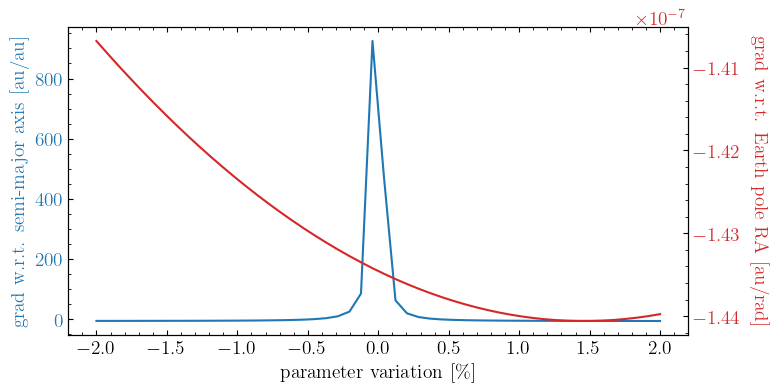

In [10]:
fig, ax1 = plt.subplots(figsize=(8, 4))

color1 = 'tab:blue'
color2 = 'tab:red'

ax1.plot(np.linspace(-2,2,50), semi_grads, label="semi", color=color1)
ax1.set_xlabel('parameter variation [\\%]')
ax1.set_ylabel('grad w.r.t. semi-major axis [au/au]', color=color1)


ax2 = ax1.twinx()
ax2.plot(np.linspace(-2,2,50), earth_pole_ra_grads, label="earth_pole_ra", color=color2)
ax2.set_ylabel('grad w.r.t. Earth pole RA [au/rad]', color=color2, rotation=270, labelpad=20)
ax1.tick_params(axis='y', labelcolor=color1)
ax2.tick_params(axis='y', labelcolor=color2)

